In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# **Study notes - Time series modelling**

_Based on_ _https://online.stat.psu.edu/stat510/ and_ _Shumway, R., Stoffer, D. (2011). Time series analysis and its applications, with R examples, 3rd edition. Springer New York Dordrecht Heidelberg London. e-ISBN 978-1-4419-7865-3_

These are my study notes on time series modelling. It's basically just me trying to explain the topic to myself. Maybe it's useful to others.

#### **What are time series, and why are they different from other data sets?**

A time series is just a sequence of measurements of a variable (GDP, wind speed, population size, no. users, no. transactions, etc.) over time, where every data point has a time associated with it (typically called a 'time stamp'). Here's a manual example:

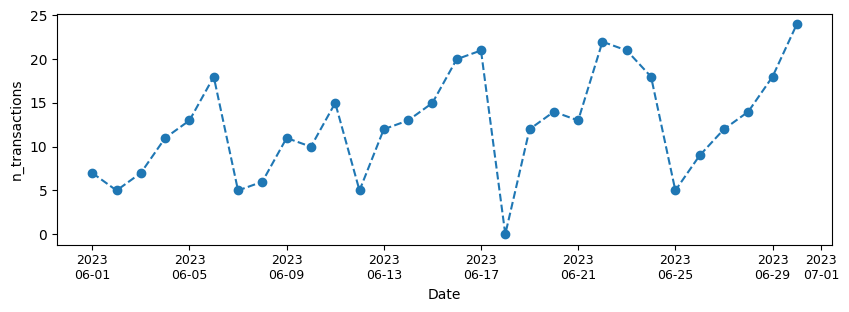

In [2]:
daily_transactions = pd.DataFrame({
    'date': pd.date_range(start='2023-06-01', end='2023-06-30', freq='D'),
    'n': [7, 5, 7, 11, 13, 18, 5, 6, 11, 10, 15, 5, 12, 13, 15, 20, 21, 0, 12, 14, 13, 22, 21, 18, 5, 9, 12, 14, 18, 24],
})

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o')
ax.set_ylabel('n_transactions')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax.tick_params(axis='x', labelsize=9)
ax.set_xlabel('Date')
plt.show()

When variables are measured over time, data points that are close to each other are unlikely to be independent. This non-independence prevents the use classical statistical approaches (OLS, ANOVA, etc.) to model temporal trends in this data. For instance, regressing a variable $x$, which we have measured over time, onto time $t$ using a model like $x = \beta_0 + \beta_1t + \epsilon$ would very likely have _autocorrelated_ residuals due to their temporal proximity. With the above data, that would look like this:

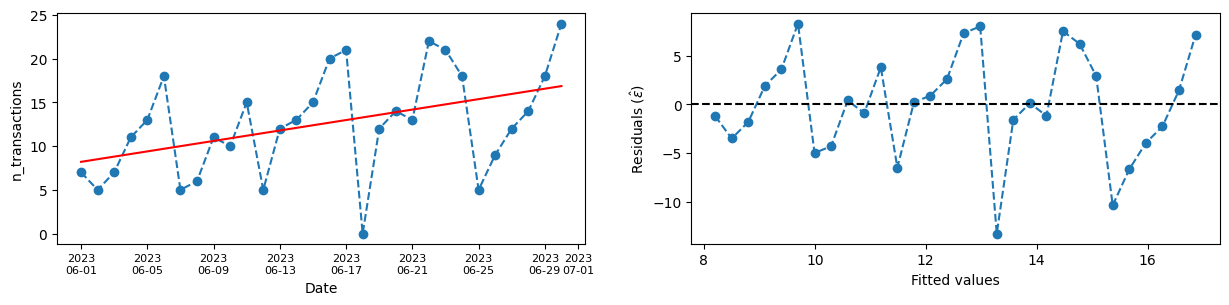

In [3]:
daily_transactions['date_num'] = (daily_transactions['date'] - pd.to_datetime('2023-06-01')).dt.days

X = daily_transactions['date_num'].values.reshape(-1, 1) 
y = daily_transactions['n'].to_numpy()

model = LinearRegression()
model.fit(X, y)
ypred = model.predict(X)
epsilon_hat = y - ypred 

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o', label='data')
ax[0].plot(daily_transactions['date'], ypred, color='red', label='model')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('n_transactions')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax[0].tick_params(axis='x', labelsize=8)
ax[1].plot(ypred, epsilon_hat, marker='o', linestyle='--')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel(r'Residuals ($\hat{\epsilon})$')
plt.show()

Clearly, residuals are autocorrelated, so a simple OLS doesn't work because we'd violate the OLS assumption of independent residuals. The strong residual autocorrelation also indicates there's something major missing from this OLS model, namely the fact that datapoints are **not independent** in time. That is, high values tend to be surrounded by high values, and low values tend to be surrounded by low values. Further, this 'inertia' likely results from underlying *mechanisms* that keep high values high and low values low, and this happens throughout the entire time series.

#### **Autoregressive time series models**

So an OLS of $x$ on $t$ doesn't work because of autocorrelation. However, if we reframe the problem by saying that $x$ is a function of its own past values, $x_t = f(x_{t-1}, x_{t-2}, ...)$, we could use autocorrelation to model $x$'s temporal evolution. We're basing this on the assumption that the response variable itself somehow 'stores' all the effects of its driving factors, and that we can use that regularity to predict what's going to happen next. Obviously, this will only succeed if those regularities really do exist and are strong enough, or in other words, if there really is enough **structure** in the data.

Shumway & Stoffer (2011) use the word *smoothness* to refer to the fact that time series with autocorrelation have values that don't just move up and down haphazardly, but rather seem 'tied' to past observations, either positively or negatively. Thus, the goal of any mathematical model of a time series is to mimic that smoothness.

##### **Notation**

A time series can be represented as a sequence of values $x_{1}$, $x_{2}$, ..., $x_{n}$, each of which is a **realization** of an underlying stochastic process. $x_{t}$ represents any particular value along that sequence, at some time $t$. Past or future values of the series are denoted as $x_{t-1}$, $x_{t-2}$, $x_{t-h}$, $x_{t+1}$, etc., where $t-1$, $t-2$, $t-h$, $t+h$ etc. indicate the number of time units we're looking into the past or the future. The number being subtracted or added to $t$ in the subscripts is the **lag**, denoted as $h$ whenever we refer to an unknown lag.

##### **Autoregressive (AR) models are meant to represent underlying stochastic processes**

The simplest AR model is an AR(1), an autoregressive model of order 1: $x_{t}=\delta+\phi_{1}~x_{t-1}+w_{t}$, where $x_{t}$ is the current value, $x_{t-1}$ is the previous value, $\delta$ = a constant term (like a bias), $\phi_1$ = autocorrelation coefficient for lag 1, and $w_{t}$ is *random noise*.

The last term $w_{t}$ is analogous to $\epsilon_i$ in OLS - it represents the *stochastic nature* of the model. This means that $w$ is what turns $x$ into a random variable, and each observation in the time series $x_t$ into a *realization* of that random variable. And like $\hat{\epsilon}_i = y_i - \hat{y}_i$ in OLS, when we fit an autoregressive model, $\hat{w}_t = x_t - \hat{x}_t$, that is, we use the observed residuals to get estimate $w_t$.

Since $w_t$ is random, we need a distribution for it, and in many cases it's useful to assume a normal distribution mean 0 and a variance of some value $\sigma_w$ (which we estimate from the data as $\hat{w}_t$, as mentioned above). Further, we also assume that, across all values of $t$, that distribution is *the same* (e.g., always normal, instead of normal for certain values of $t$ and exponential for others). Also, we assume that the properties (mean, variance, ...) of $w_t$'s distribution at one value of $t$ are disconnected from those at any other value of $t$. Formally, we say that $w_{t}$ is *'iid'* - **independent and identically distributed**. If we didn't assume that we'd have to use the data to estimate the parameters of a different distribution for $w_{t}$ at every $t$, and that's just too many parameters for any data set.

With this bit of theory, let's go over examples of increasing complexity using synthetic data, which we'll generate by drawing samples from autoregressive stochastic processes with parameters we specify. We'll manually generate the time series and then fit models using that data. Using synthetic data allows us to directly compare parameter estimates with their actual values, something that's obviously not possible in practice. We're doing it here to illustrate that **autoregressive (AR) models are meant to represent underlying stochastic processes**.

##### **Notes on how to interpret model quality**

- Forecasts (and also fitted values) represent the **expected value**<sup>*</sup> of the variable we're modelling, so they cannot be directly compared to the observed test datapoints because these represent individual realizations (random draws) of the random variable. It just doesn't make sense to expect that individual draws from a distribution **always** equal the distribution's expected value. If that happened, there'd be no need for statistics.

- Because of this, even with an accurate, well-specified model, there **will** be deviations between individual test datapoints and the forecasted mean. That's what residuals are! In this sense, residuals are not simply modelling error; they are **inherent** to modelling stochastic processes, and with a good model, they consist only of *irreducible* error.

- What we actually should expect is not for individual residuals but their **aggregate** (mean, median, root-mean-square, ...) to be close to zero. More specifically:
    - residuals should be **unbiased** -> mean, median, root-mean-square, etc. of residuals should be close to zero
    - residuals should be **homogeneous** -> no evidence of heteroskedasticity
    - residuals should be **uncorrelated** > no evicence of autocorrelation
    - $(1-\alpha)$ % (e.g., 95%) of the test datapoints should fall within $(1-\alpha)$ % confidence intervals around the forecasted expected values

If any of these fail, there's likely information left in the residuals that should be captured by the model, i.e., residuals not only contain irreducible but also reducible error, and that means the model is not well specified / well trained.

These points also apply in a purely predictive modelling context. Any model, however big/complex, yields **probabilistic** predictions, and is therefore subject to the above rules.

<font size="2"><sup>*</sup> Conditioned on the past and model parameters</font>

So, moving on to the examples. Some helper functions:

In [ ]:
def train_test_model(x, test_size, order, seasonal_order):
    test_size = 50
    x_train = x[:-test_size]
    x_test = x[-test_size:]

    model = SARIMAX(
        endog=x_train, 
        order=order, 
        seasonal_order=seasonal_order,
        trend='c'    
    )
    model_fit = model.fit()

    print(model_fit.summary())

    in_sample_prediction = model_fit.get_prediction(start=0, end=len(x_train) - 1)
    fitted_mean = in_sample_prediction.predicted_mean
    fitted_ci = in_sample_prediction.conf_int(alpha=0.1)

    long_run_forecasts = model_fit.get_forecast(steps=test_size)
    long_run_forecasts_mean = long_run_forecasts.predicted_mean
    long_run_forecasts_ci = long_run_forecasts.conf_int(alpha=0.1)

    # make rolling one-step-ahead predictions on test data
    predictions_mean = list()
    predictions_ci_low = list()
    predictions_ci_high = list()
    for i in range(test_size):
        forecast = model_fit.get_forecast(steps=1)
        forecast_mean = forecast.predicted_mean.iloc[0]
        forecast_ci = forecast.conf_int(alpha=0.1)

        predictions_mean.append(forecast_mean)
        predictions_ci_low.append(forecast_ci.iloc[0, 0])
        predictions_ci_high.append(forecast_ci.iloc[0, 1])        
        model_fit = model_fit.append([x_test.iloc[i]]) # Update the model's internal state with the actual observation from the test set

    return {
        'x_train': x_train,
        'x_test': x_test,
        'model_fit': model_fit, 
        'fitted_mean': fitted_mean, 
        'fitted_ci': fitted_ci, 
        'predictions_mean': predictions_mean, 
        'predictions_ci_low': predictions_ci_low,
        'predictions_ci_high': predictions_ci_high,
        'long_run_forecasts_mean': long_run_forecasts_mean,
        'long_run_forecasts_ci': long_run_forecasts_ci,
    }


def plot(results):
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(2, 4)
    ax00 = fig.add_subplot(gs[0, :3])
    ax00.set_title('Residuals')
    ax00.plot(results['model_fit'].resid)
    ax00.axhline(y=0, linestyle='--', color='black')
    ax10 = fig.add_subplot(gs[1, :3])
    ax10.set_title('Modelling')
    ax10.plot(results['x_train'], label='train data')
    ax10.plot(results['fitted_mean'], color='red', label='fitted mean')
    ax10.fill_between(results['x_train'].index, results['fitted_ci'].iloc[:, 0], results['fitted_ci'].iloc[:, 1], color='red', alpha=0.2, label='fitted values ci')
    ax10.plot(results['x_test'], label='test data')
    ax10.plot(results['x_test'].index, results['predictions_mean'], color='green', label='rolling predictions')
    ax10.fill_between(results['x_test'].index, results['predictions_ci_low'], results['predictions_ci_high'], color='green', alpha=0.2, label='rolling predictions ci')
    ax10.plot(results['long_run_forecasts_mean'], color='black', label='long run forecast')
    ax01 = fig.add_subplot(gs[0, 3])
    ax11 = fig.add_subplot(gs[1, 3])
    ax10.legend(loc='upper center', ncol=7, fontsize='small', handlelength=0.5)
    sm.graphics.tsa.plot_acf(results['model_fit'].resid, ax=ax01)
    sm.graphics.tsa.plot_pacf(results['model_fit'].resid, ax=ax11)
    plt.tight_layout()
    plt.show()

##### **Synthetic AR(1), forecast with SARIMAX(1,0,0)(0,0,0)$_0$**

Autoregressive order-1 process, no moving average terms, no seasonality, no trend.

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  150
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -411.543
Date:                Sat, 16 Nov 2024   AIC                            829.086
Time:                        14:43:51   BIC                            838.118
Sample:                             0   HQIC                           832.756
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3146      0.313      1.007      0.314      -0.298       0.927
ar.L1          0.4212      0.085      4.932      0.000       0.254       0.589
sigma2        14.1267      1.419      9.952      0.0

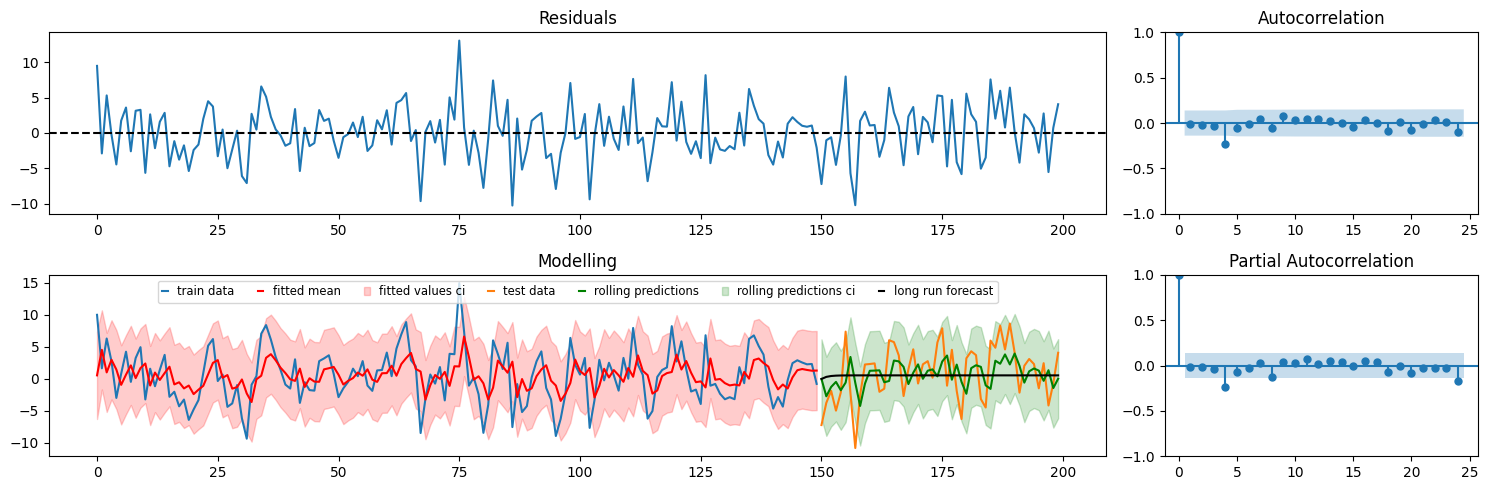

In [12]:
def generate_ar_1(N, sigma, x0, phi_1, delta):
    
    x = np.zeros(N)
    w = np.random.normal(0, sigma, size=N)
    x[0] = x0

    for t in np.arange(1, N, 1):
        x[t] = delta + phi_1*x[t - 1] + w[t]
 
    x = pd.DataFrame({'t': np.arange(0, N, 1), 'x': x}).set_index('t')

    return x

x = generate_ar_1(N=200, sigma=1, x0=10, phi_1=0.45, delta=0)
results = train_test_model(x, test_size=50, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
plot(results)

Overall, the fit is good, and we can say the model captures the structure of the underlying AR(1) stochastic process:

- Parameter estimates are close to their actual values; compare the estimates shown in the SARIMAX results summary with the values used in the call to the function
- No evidence of autocorrelation in residuals; Ljung-Box statistic not significantly different from 0
- No evidence of deviation from normality in residual distribution: Jarque-Bera statistic not significantly different from zero; also, skewness close to zero and kurtosis close to 3
- No evidence of heterosckedasticity in residuals: H statistic not significantly different from zero
- Finally, most test datapoints fall within the 95% prediction intervals

We have both long-run (black line) and rolling one-step-ahead (green line and green area) forecasts. Long-run forecasts in AR(1) models flatten out and stabilize at the expected value of the AR(1) process. This happens because forecasts (out-of-sample predictions) in an AR(1) model can be written as $\hat{x}_{t+h} = \delta\sum_{k=0}^{k=h-1}\phi^k + \phi^hx_t = \delta\frac{1-\phi^h}{1-\phi} + \phi^hx_t$, and this expression tends to $\hat{x}_{t+h} = \frac{\delta}{1-\phi}$ as $h \to \infty$ (assuming stationarity, i.e., $\phi < 1$).

- Rolling forecasts are more variable simply because we use the observed test datapoints and we make only one forecast into the future.

- Forecasts lag behind whenever there are sharp changes in the data because there's nothing in the model that allows it to anticipate those changes. The model always needs a few time steps to catch up.


2. synthetic ma(1), forecast with sarimax(0,0,1)(0,0,0,0), explain difference to ar(1) check resid autocorr, normality, homosckedast., forecast quality
3. add trend to ar(1), forecast with sarimax(1,1,0)(0,0,0,0), check resid autocorr, normality, homosckedast., forecast quality
4. add regular seasonality to ar(1), forecast with sarimax(1,0,0)(1,0,0,s), check resid autocorr, normality, homosckedast., forecast quality
5. what happens when seasonality becomes irregular? -> sunspot dataset

In [6]:
# autocorrelation = cov(x_t, x_tminus1)/(sd(x_t)*sd(x_tminus1))
# ********************
# The AR(1) model
# *******************

# x_t = delta + phi_1*x_tminus1 + w_t

# assumptions:
#   - x_t weakly stationary
#   - w_t --> iid N(0, sigma_w^2)
#   - w_t independent of x

# properties:
#   - expected value E(x_t):
#     E(x_t) = E(delta + phi_1*x_tminus1 + w_t)
#     E(x_t) = E(delta) + E(phi_1*x_tminus1) + E(w_t)
#     E(x_t) = delta + phi_1*E(x_tminus1) + 0 
#     Due to stationarity, E(x_t) = E(x_tminus1). Then,
#     E(x_t) = delta / (1 - phi_1)
#
#   - variance Var(x_t):
#     Var(x_t) = Var(delta + phi_1*x_tminus1 + w_t)
#     ...assuming x_t and w_t (errors) are independent, and noting that delta and
#        phi_1 are constants:
#     Var(x_t) = 0 + Var(phi_1*x_tminus1) + Var(w_t)
#     Var(x_t) = phi_1^2*Var(x_tminus1) + sigma_w^2
#     ...assuming series is stationary, Var(x_t) = Var(x_tminus1)
#     Var(x_t) = sigma_w^2 / (1 - phi_1^2)
#
#   - autocovariance Cov(x_t, x_tminush) (h = lag):
#     ...writing x_t by substituting x_minus1 (use model without delta for simplicity)
#        going from x_t back to x_tminush
#     x_t = phi_1*x_tminus1 + w_t
#     x_t = phi_1^2*x_tminus2 + phi_1*w_tminus1 + w_t
#     x_t = phi_1^3*x_tminus3 + phi_1 2*w_tminus2 + phi_1*w_tminus1 + w_t
#     ... at t_minush:
#     x_t = phi_1^h*x_tminush + sum{i=0...h-1}(phi_1^i*w_tminusi)
#     ... substituting this for x_t in definition of cov:
#     Cov(x_t, x_tminush) = Cov(phi_1^h*x_tminush + sum{i=0...h-1}(phi_1^i*w_tminusi),
#                               x_tminush)
#     Cov(x_t, x_tminush) = Cov(phi_1^h*x_tminush, x_tminush) +
#                           Cov(sum{i=0...h-1}(phi_1^i*w_tminusi), x_tminush)
#     ... noting that the second Cov is zero, since the w_t are iid and independent
#         of the x_t, we get:
#     Cov(x_t, x_tminush) = phi_1^h*Cov(x_tminush, x_tminush) + 0
#     Cov(x_t, x_tminush) = phi_1^h*Var(x_tminush)
#     ... for AR(1), h = 1:
#     Cov(x_t, x_tminus1) = (phi_1*sigma_w^2)/(1 - phi_1^2)
#
#   - lag-1 autocorrelation = phi_1*Var(x_t)/Var(x_t) = phi_1


MA processes

ARIMA

VAR

GARCH

state-space models

LSTM
